# Desafío - Machine Learning 

In [14]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, RepeatedKFold, GridSearchCV, train_test_split
from warnings import WarningMessage
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, scale
import multiprocessing

WarningMessage = False
plt.rcParams["figure.dpi"] = 150
plt.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [3]:
# Datos de entrenamiento
data_web = pd.read_csv("data/usuarios_win_mac_lin_train.csv")
data_web.describe()

# Datos de validacion
data_validation = pd.read_csv("data/data_validation_without_class.csv")

## Analisis de los datos

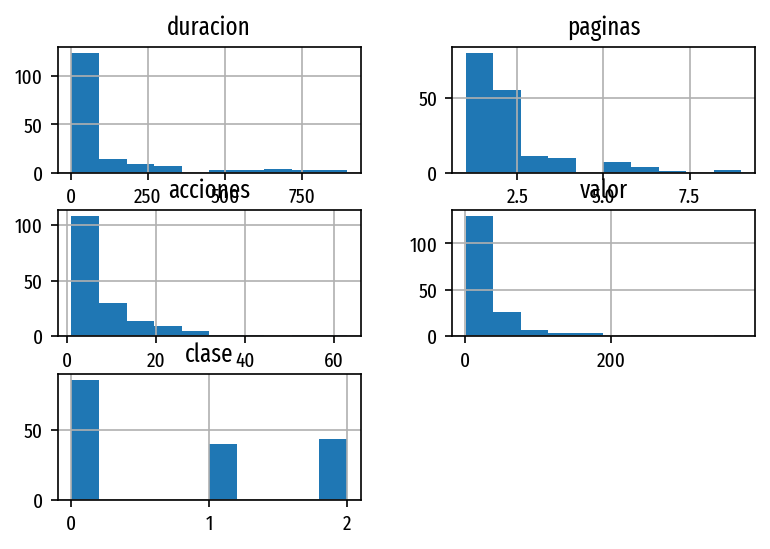

In [62]:
hist = data_web.hist(bins=10)

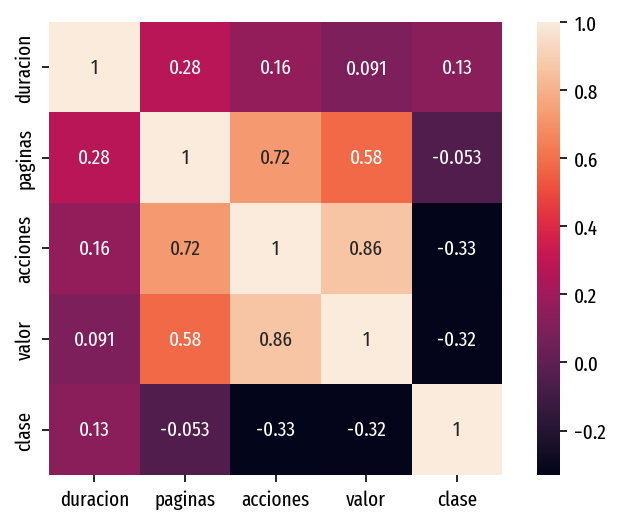

In [41]:
corr = data_web.corr()
sns.heatmap(corr, annot = True, square = True);

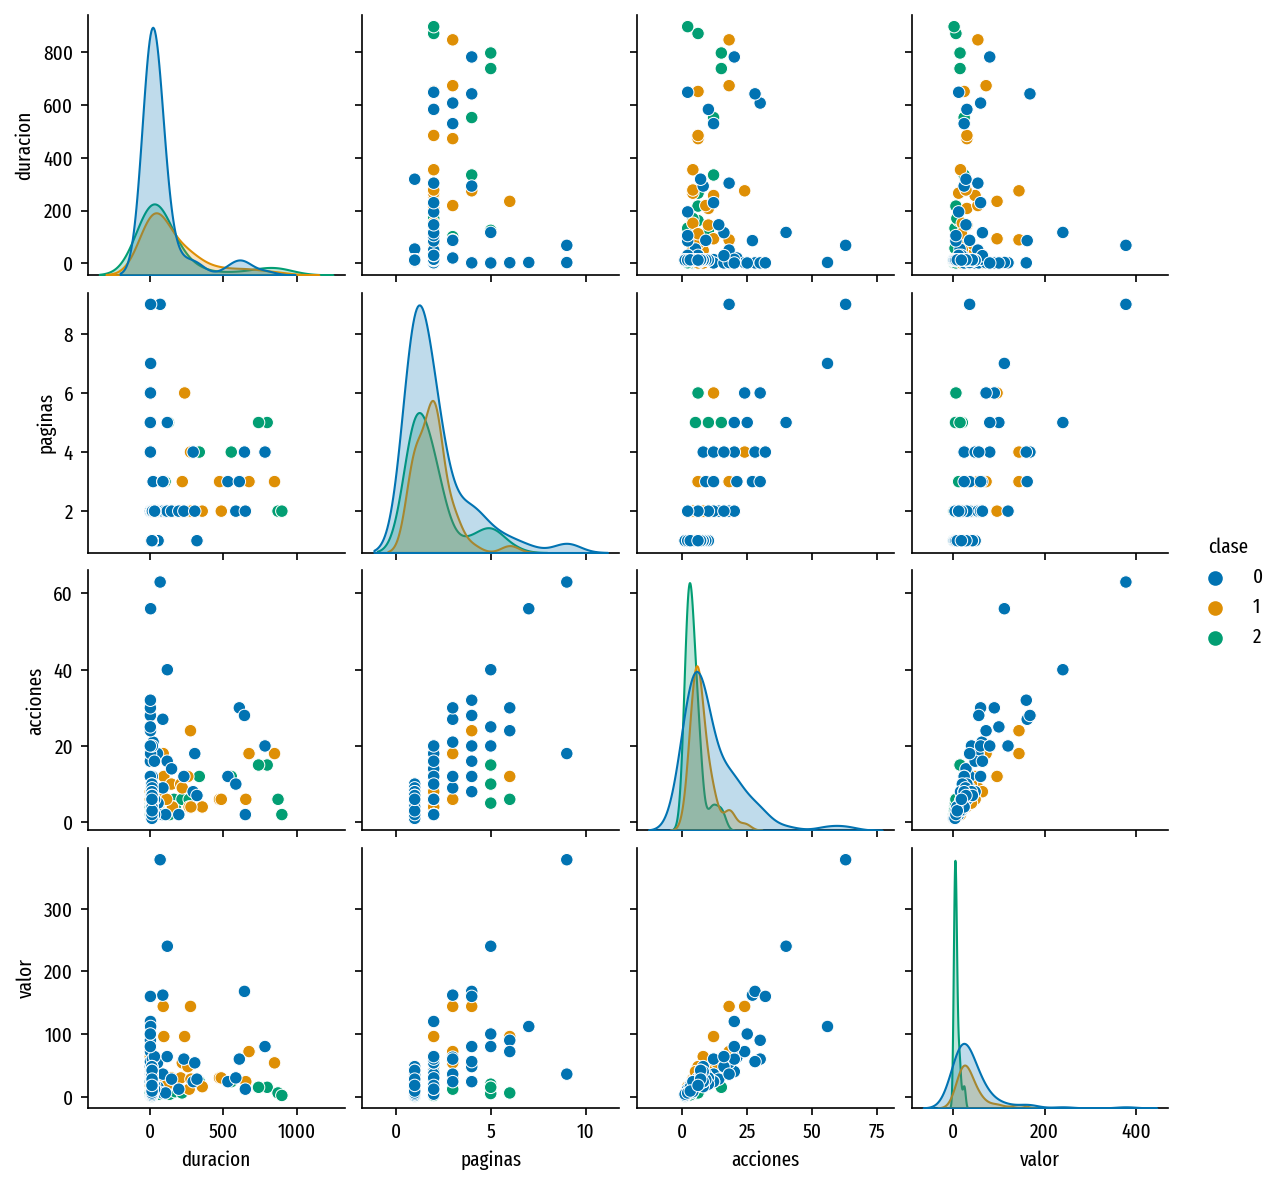

In [42]:
sns.pairplot(data_web, hue="clase", height = 2, palette = 'colorblind')

## Revision de outliers

## Análisis de componentes principales (PCA)

In [63]:
# media de cada variable
print('Media de las variables')
print(data_web.mean(axis=0))
# Varianza
print('Varianza de las variables')
print(data_web.var(axis=0))

Media de las variables
duracion    111.075729
paginas       2.041176
acciones      8.723529
valor        32.676471
clase         0.752941
dtype: float64
Varianza de las variables
duracion    40987.298106
paginas         2.252732
acciones       83.467490
valor        2002.740863
clase           0.707832
dtype: float64


Hay que estandarizar los datos para que variables con alta media y varianza no dominen el PCA.

In [44]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
pca_pipe = make_pipeline(StandardScaler(), PCA()) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(data_web)

# Se extrae el modelo entrenado del pipeline
modelo_pca = pca_pipe.named_steps['pca']

In [45]:
modelo_pca.get_params()

{'copy': True,
 'iterated_power': 'auto',
 'n_components': None,
 'random_state': None,
 'svd_solver': 'auto',
 'tol': 0.0,
 'whiten': False}

Convierto los componentes del modelo para analizar sus combinaciones lineales e importancia

In [64]:
# Se combierte el array a dataframe para añadir nombres a los ejes.
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = data_web.columns,
    index   = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
)

,duracion,paginas,acciones,valor,clase
PC1,0.159889,0.505198,0.592426,0.558397,-0.237558
PC2,0.698859,0.273012,-0.044904,-0.123858,0.647845
PC3,0.682919,-0.254155,-0.105022,-0.136200,-0.662908
PC4,-0.139296,0.733213,-0.149168,-0.584695,-0.280848
PC5,-0.015825,-0.260850,0.783412,-0.558957,0.074435


Analisis visual

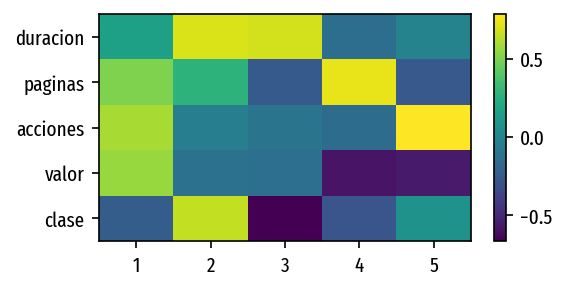

In [47]:
# Heatmap componentes
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 2))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
plt.yticks(range(len(data_web.columns)), data_web.columns)
plt.xticks(range(len(data_web.columns)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar()

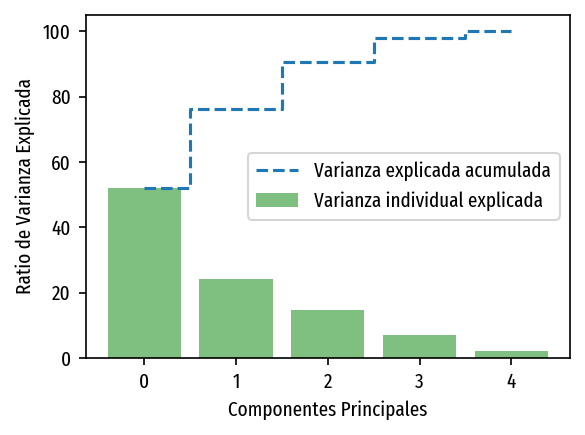

In [48]:
# A partir de los autovalores, calculamos la 
# varianza explicada (% representatividad)

var_exp = modelo_pca.explained_variance_ratio_ *100  # ratio de varianza explicada por 100 (para que quede en %)
cum_var_exp = np.cumsum(var_exp) # varianza acumulada por componente 

n_components = len(modelo_pca.components_)
# Representamos en un diagrama de barras la varianza explicada por cada autovalor, y la acumulada
# with plt.style.context('seaborn-pastel'):
plt.figure(figsize=(4, 3))

plt.bar(range(n_components), var_exp, alpha=0.5, align='center',
        label='Varianza individual explicada', color='g')
plt.step(range(n_components), cum_var_exp, where='mid', linestyle='--', label='Varianza explicada acumulada')
plt.ylabel('Ratio de Varianza Explicada')
plt.xlabel('Componentes Principales')
plt.legend(loc='best')
plt.tight_layout()
## Pendiente -> anotar labels 

# Modelo 1 -  DecisionTree

Clasificador DecisionTree


In [58]:
X=data_web[['duracion', 'paginas', 'acciones', 'valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 

In [57]:
# Con menos componentes
X=data_web[['acciones','valor']]  # Features
y=data_web['clase']  # Labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y) 

In [51]:
# Árbol de desición
modelo_tree=DecisionTreeClassifier(max_depth = 3, random_state = 1, )
# fit
modelo_tree.fit(X_train,y_train)

y_pred=modelo_tree.predict(X_test)

In [52]:
modelo_tree.feature_importances_

array([0.45649294, 0.54350706])

In [53]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7058823529411765


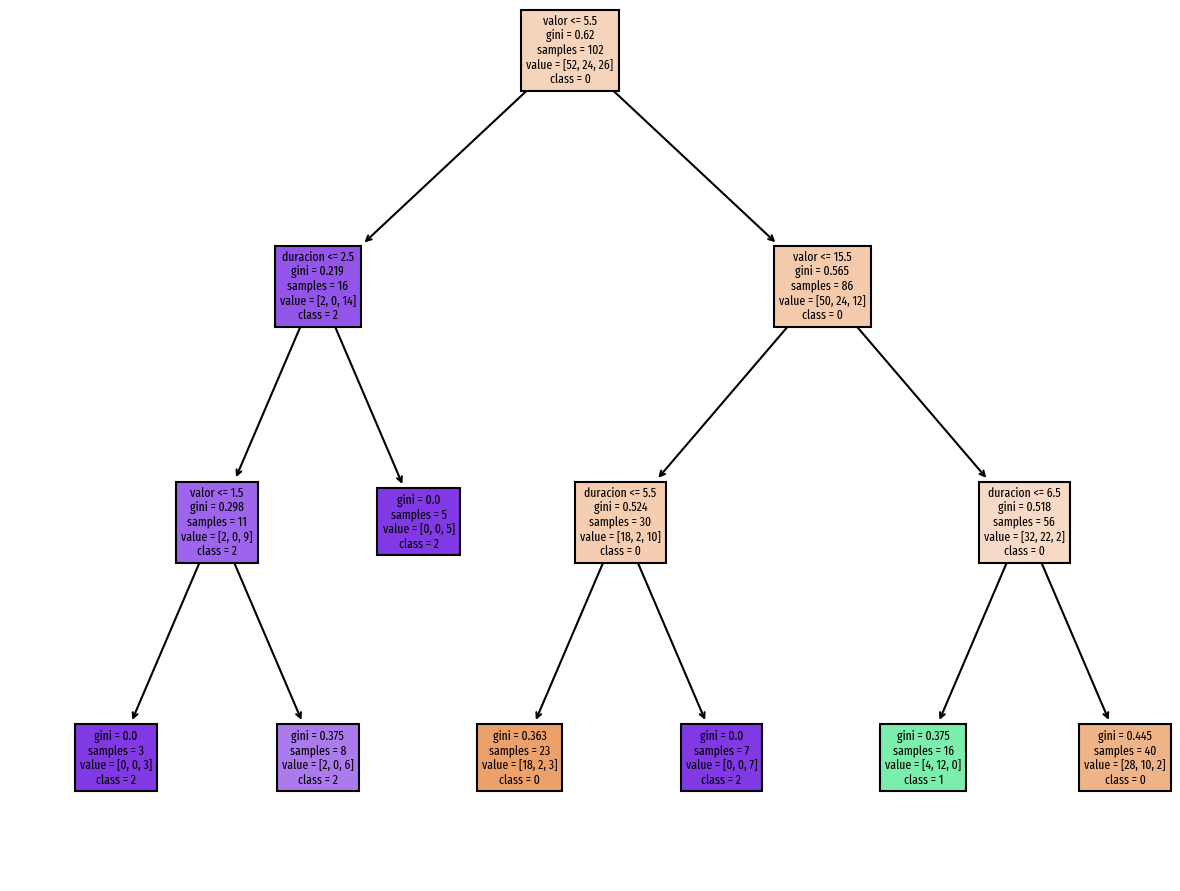

In [55]:
#fn = ['duracion', 'paginas', 'acciones', 'valor']
fn = ['duracion', 'valor']
cn = ["0", "1", "2"]

plt.figure(figsize = (5,4))
plot_tree(modelo_tree, feature_names = fn, class_names = cn, filled = True)
plt.tight_layout(h_pad=0.5, w_pad=0.5)

# Si el gini tiende a cero, el error tiende a cero

In [56]:
predicciones = modelo_tree.predict(X = X_test)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.68      0.76      0.72        34
           1       0.62      0.62      0.62        16
           2       0.86      0.67      0.75        18

    accuracy                           0.71        68
   macro avg       0.72      0.69      0.70        68
weighted avg       0.72      0.71      0.71        68



# Modelo 2 - Random Forest



In [57]:
modelo_rf =  RandomForestClassifier(
            n_estimators = 100,
            n_jobs       = -1,
            max_depth= 6,
            random_state = 1
         )
      
modelo_rf.fit(X_train.values, y_train.values)

RandomForestClassifier(max_depth=6, n_jobs=-1, random_state=1)

In [65]:
# Accuracy
# ==============================================================================
y_pred = modelo_rf.predict(X_test.values)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7647058823529411


In [66]:
predicciones = modelo_rf.predict(X = X_test.values)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.85      0.65      0.73        34
           1       0.54      0.81      0.65        16
           2       0.94      0.94      0.94        18

    accuracy                           0.76        68
   macro avg       0.78      0.80      0.78        68
weighted avg       0.80      0.76      0.77        68



In [67]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = ParameterGrid(
                {'n_estimators': [100,150],
                 'max_features': [1,2],
                 'max_depth'   : [None,3, 6, 10],
                 'criterion'   : ['gini', 'entropy']
                }
            )

# Loop para ajustar un modelo con cada combinación de hiperparámetros
# ==============================================================================
resultados = {'params': [], 'oob_accuracy': []}

for params in param_grid:
    
    modelo = RandomForestClassifier(
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123,
                ** params
             )
    
    modelo.fit(X_train.values, y_train)
    
    resultados['params'].append(params)
    resultados['oob_accuracy'].append(modelo.oob_score_)
    print(f"Modelo: {params} \u2713")

# Resultados
# ==============================================================================
resultados = pd.DataFrame(resultados)
resultados = pd.concat([resultados, resultados['params'].apply(pd.Series)], axis=1)
resultados = resultados.sort_values('oob_accuracy', ascending=False)
resultados = resultados.drop(columns = 'params')
resultados.head(4)

Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': None, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 100} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 1, 'n_estimators': 150} ✓
Modelo: {'criterion': 'gini', 'max_depth': 6, 'max_features': 2, 'n_estimators': 100} ✓
Modelo: {'criterion'

,oob_accuracy,criterion,max_depth,max_features,n_estimators
13,0.735294,gini,10.0,1,150
1,0.735294,gini,NaN,1,150
27,0.725490,entropy,6.0,2,150
11,0.725490,gini,6.0,2,150


In [68]:
# Error de test del modelo final
# ==============================================================================
modelo_rf =  RandomForestClassifier(
            n_estimators = 150,
            n_jobs       = -1,
            max_depth= 6,
            random_state = 1,
            max_features = 2,
            criterion='entropy'
         )

modelo_rf.fit(X_train.values, y_train)        

predicciones = modelo_rf.predict(X = X_test.values)
mat_confusion = metrics.confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = metrics.accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
print(mat_confusion)
print("")
print(f"El accuracy de test es: {100 * accuracy} %")

Matriz de confusión
-------------------
[[22 11  1]
 [ 3 13  0]
 [ 1  0 17]]

El accuracy de test es: 76.47058823529412 %


# Modelo 3 - RandomForest con PCA

In [59]:
# Entrenamiento modelo PCA con escalado de los datos
# ==============================================================================
# N components = 4 por el análisis anterior
pca_pipe = make_pipeline(StandardScaler(), PCA(n_components=4), RandomForestClassifier(random_state=1, class_weight='balanced') ) # Estandar Scaler estandariza, PCA obtiene componentes
pca_pipe.fit(X_train.values, y_train.values)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=4)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=1))])

Reviso  metricas del modelo

In [60]:
predicciones = pca_pipe.predict(X = X_test.values)
print(metrics.classification_report(y_true = y_test,
y_pred = predicciones
))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76        17
           1       0.62      0.62      0.62         8
           2       0.78      0.78      0.78         9

    accuracy                           0.74        34
   macro avg       0.72      0.72      0.72        34
weighted avg       0.74      0.74      0.74        34



In [61]:
pca_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'pca', 'randomforestclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'pca__copy', 'pca__iterated_power', 'pca__n_components', 'pca__random_state', 'pca__svd_solver', 'pca__tol', 'pca__whiten', 'randomforestclassifier__bootstrap', 'randomforestclassifier__ccp_alpha', 'randomforestclassifier__class_weight', 'randomforestclassifier__criterion', 'randomforestclassifier__max_depth', 'randomforestclassifier__max_features', 'randomforestclassifier__max_leaf_nodes', 'randomforestclassifier__max_samples', 'randomforestclassifier__min_impurity_decrease', 'randomforestclassifier__min_samples_leaf', 'randomforestclassifier__min_samples_split', 'randomforestclassifier__min_weight_fraction_leaf', 'randomforestclassifier__n_estimators', 'randomforestclassifier__n_jobs', 'randomforestclassifier__oob_score', 'randomforestclassifier__random_state', 'randomforestclassifier__verbose', 'randomforestclass

In [62]:
param_dict = {
            "randomforestclassifier__criterion": ['gini', 'entropy'],
            "randomforestclassifier__n_estimators":[100,150,200],
            'randomforestclassifier__criterion': ['gini', 'entropy'],
            'randomforestclassifier__max_features':   [1,2,3,4]

              }

estimator = GridSearchCV(pca_pipe,
                         param_dict,
                         verbose=2)


In [63]:
estimator.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=100; total time=   0.1s
[CV] END randomforestclassifier__criterion=gini, randomforestclassifier__max_features=1, randomforestclassifier__n_estimators=150; total time=   0.1s
[CV] END randomforestclassifier__crite

GridSearchCV(estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(n_components=4)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight='balanced',
                                                               random_state=1))]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_features': [1, 2, 3, 4],
                         'randomforestclassifier__n_estimators': [100, 150,
                                                                  200]},
             verbose=2)

In [64]:
modelo_final = estimator.best_estimator_

In [66]:
#  test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test)

In [68]:
print(
    metrics.classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.62      0.62      0.62         8
           2       0.80      0.89      0.84         9

    accuracy                           0.76        34
   macro avg       0.75      0.76      0.75        34
weighted avg       0.77      0.76      0.76        34



## ADA Boost

https://machinelearningmastery.com/adaboost-ensemble-in-python/  
https://www.cienciadedatos.net/documentos/py09_gradient_boosting_python.html